In [1]:
import sys, os
%load_ext autoreload
%autoreload 2
sys.path.append('../../src')
sys.path.append(os.path.abspath(os.path.join('..')))
import utils

import torch
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import Hist

from torch.utils.data import DataLoader
from torch.nn import Sigmoid

from tensordict.nn import TensorDictModule, TensorDictSequential

from deepmuonreco.data import InnerTrackSelectionDataset
from deepmuonreco.nn import InnerTrackSelectionTransformer, Normalize
from deepmuonreco.nn.utils import init_params
from deepmuonreco.nn import SelectedBCEWithLogitsLoss

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
import json

plt.style.use(hep.style.CMS)

In [2]:
model_path = "9c1d2c41dba54beeb0c57456"
checkpoint_path = f"../../.aim/default/{model_path}/best_model.pt"
norm_stats_path = "../../configs/norm-stats/mu2024pu1M.json"
data_path = "../../data/mu2024pu/test.root"


In [3]:
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

In [4]:
test_set = InnerTrackSelectionDataset(path=data_path)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=InnerTrackSelectionDataset.collate
)

print(f"Test dataset loaded: {len(test_set)}")

Test dataset loaded: 19999


In [6]:
device = torch.device("cpu")
with open(norm_stats_path, "r") as f:
    norm_stats = json.load(f)
model = utils.load_model(
    checkpoint_path=checkpoint_path,
    device=device,
    dim_model=128,
    dim_feedforward=256,
    num_heads=8,
    num_layers=4,
    norm_stats=norm_stats
)

In [7]:
import time
import psutil

tracks, segs, hits = [], [], []
targets, logits, scores = [], [], []

process = psutil.Process(os.getpid())
latencies = []
memories = []

with torch.no_grad():
    model = model.to(device).eval()
    for batch in tqdm(test_loader):

        mem_before = process.memory_info().rss / 1e6  # MB
        start = time.perf_counter()

        output = model(batch)

        end = time.perf_counter()
        mem_after = process.memory_info().rss / 1e6
        latency = (end - start) * 1000  # ms
        mem_usage = mem_after - mem_before

        latencies.append(latency)
        memories.append(mem_usage)

        track_mask = ~batch["pad_masks"]["track"].view(-1)
        seg_mask = ~batch["pad_masks"]["seg"].view(-1)
        hit_mask = ~batch["pad_masks"]["hit"].view(-1)

        track = batch["track"].reshape(-1, batch["track"].shape[-1])[track_mask]
        seg   = batch["seg"].reshape(-1, batch["seg"].shape[-1])[seg_mask]
        hit   = batch["hit"].reshape(-1, batch["hit"].shape[-1])[hit_mask]

        target = batch["target"].reshape(-1)[track_mask]
        logit  = output["logits"].reshape(-1)[track_mask]
        score  = output["score"].reshape(-1)[track_mask]

        tracks.append(track)
        segs.append(seg)
        hits.append(hit)
        targets.append(target)
        logits.append(logit)
        scores.append(score)

  0%|          | 0/19999 [00:00<?, ?it/s]

100%|██████████| 19999/19999 [20:00<00:00, 16.66it/s]


In [14]:
print(latencies)
print(memories)

[151.4325679745525, 37.29400411248207, 59.69177791848779, 38.55176386423409, 37.66309097409248, 59.234766056761146, 80.83595498465002, 54.62618009187281, 58.30196291208267, 40.26551591232419, 29.370682081207633, 60.65719900652766, 22.532246075570583, 27.76275691576302, 39.64937385171652, 51.04166897945106, 85.46479512006044, 81.7445800639689, 28.234769124537706, 49.62100903503597, 89.6601639688015, 47.0227999612689, 101.97093989700079, 77.09353999234736, 69.83613898046315, 37.851884961128235, 16.8329409789294, 139.72251280210912, 30.166111886501312, 139.27096710540354, 53.673784947022796, 34.494836116209626, 48.04463009350002, 39.57693511620164, 38.59148290939629, 68.88628588058054, 91.31889697164297, 36.16118594072759, 45.5838090274483, 51.77833396010101, 28.71800190769136, 17.222647089511156, 20.71046084165573, 44.86628412269056, 24.4879478123039, 48.70636900886893, 15.65552013926208, 30.04749701358378, 55.504652904346585, 58.606652077287436, 20.310482941567898, 44.34322682209313, 40

TypeError: only integer scalar arrays can be converted to a scalar index

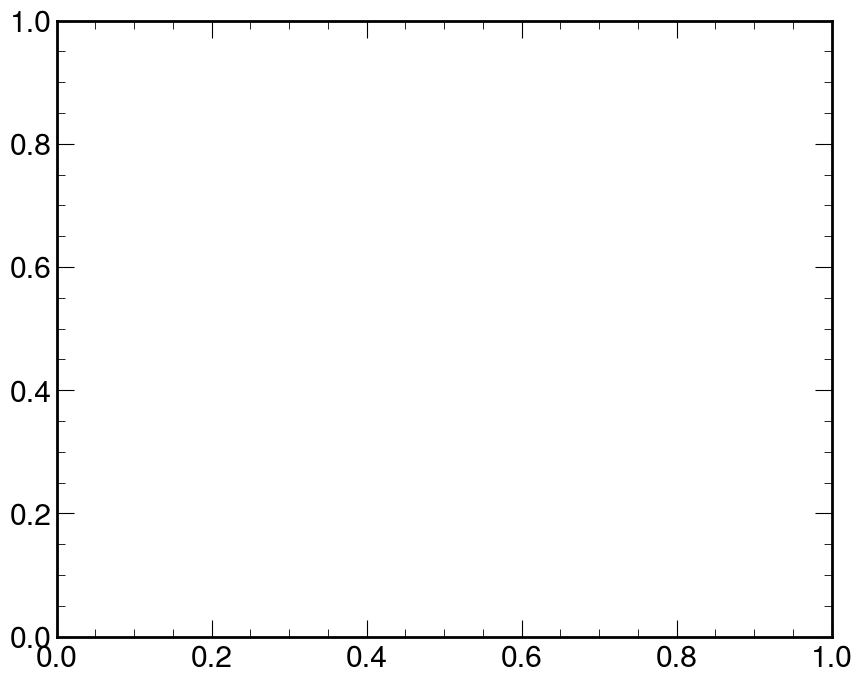

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax, h_latencies = utils.plot_hist_1d(ax=ax, data=latencies, bins=(100, 0, 10000), label='Model Latency\n' + fr'<t>: {np.mean(latencies):.1f}', color='C0', density=True, mask=None, weight=None)
ax.set_xlabel(r'Latency [ms]')
ax.set_ylabel('Normalized')
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
plt.legend(title=r'$\mu^{+}\mu^{-}$+pileup Simulation')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax, h_memories = utils.plot_hist_1d(ax=ax, data=memories, bins=(100, 0, 100), label='Model Memory Usage\n' + fr'<M>: {np.mean(latencies):.1f}', color='C2', density=True, mask=None, weight=None)
ax.set_xlabel(r'Memory [MB]')
ax.set_ylabel('Normalized')
hep.cms.label("Private Work", ax=ax, data=False, com=13.6)
plt.legend(title=r'$\mu^{+}\mu^{-}$+pileup Simulation')
plt.tight_layout()
plt.show()